In [1]:
import os
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as pp
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import maxabs_scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve, classification_report, roc_curve, auc, average_precision_score, accuracy_score

In [2]:
data_dir = os.path.join('..','data-wrangling','data','flight_data')
misc_data_dir = os.path.join('..','data-wrangling','data','misc')
feat = pd.read_csv(os.path.join(data_dir,'feat_2018.csv'), low_memory=False)
airport = pd.read_csv(os.path.join(misc_data_dir,'airport.csv'), usecols = [0, 1, 2, 3, 4, 5, 6, 11, 16, 17])
feat.head()

,month,weekDay,dayofMonth,dayofYear,hour,iata,tailNum,orgAirport,destAirport,temp,...,MemorialDay,IndependenceDay,LaborDay,ColumbusDay,VeteransDay,Thanksgiving,ChristmasDay,NxtNewYearsDay,prevArrDel,timeDiff
0,1,1,1,1,6,HA,N490HA,13830,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-5.0,-28.0
1,1,1,1,1,6,HA,N491HA,12758,12173,73.9,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-6.0,-42.0
2,1,1,1,1,6,OO,N693BR,14747,14057,34.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-3.0,-44.0
3,1,1,1,1,6,HA,N483HA,12402,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-3.0,-47.0
4,1,1,1,1,6,HA,N475HA,12982,12173,72.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-9.0,-26.0


In [3]:
grouped = feat.groupby(['orgAirport'])
idx = grouped.size().sort_values(ascending=False).iloc[:20].index.values
mask = pd.Series(np.zeros(feat.shape[0]), dtype='boolean')
for i in list(idx):
    mask = mask | (feat.orgAirport == i)
data = feat[mask]
data.head()

,month,weekDay,dayofMonth,dayofYear,hour,iata,tailNum,orgAirport,destAirport,temp,...,MemorialDay,IndependenceDay,LaborDay,ColumbusDay,VeteransDay,Thanksgiving,ChristmasDay,NxtNewYearsDay,prevArrDel,timeDiff
2,1,1,1,1,6,OO,N693BR,14747,14057,34.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-3.0,-44.0
5,1,1,1,1,6,B6,N328JB,13204,10529,57.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-19.0,-156.0
6,1,1,1,1,6,NK,N604NK,11298,11697,23.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,47.0,-241.0
7,1,1,1,1,6,UA,N61898,14107,14771,51.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-21.0,-59.0
8,1,1,1,1,6,AS,N402AS,14747,13891,34.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-4.0,-137.0


In [4]:
grouped = data.groupby(['orgAirport', 'month'])
keys = grouped.groups.keys()
cols = ['iata', 'weekDay', 'dayofMonth', 'hour', 'destAirport']
ros = RandomOverSampler(random_state=0)
logit = LogisticRegression(max_iter=1000, tol=1e-6)
param_grid = {'C': [.5, 1, 1.5, 2, 3], 'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}]}
f1 = make_scorer(f1_score , average='weighted')
logit_gscv = GridSearchCV(logit, param_grid, cv=3, scoring=f1)
index = pd.MultiIndex.from_tuples(keys, names=['orgAirport', 'Month'])
results = pd.DataFrame({'train_size': np.empty(len(keys)), 'test_size': np.empty(len(keys)), 
                        'precision': np.empty(len(keys)), 'recall': np.empty(len(keys)), 
                        'f1_score': np.empty(len(keys)), 'auc': np.empty(len(keys)), 
                        'C': np.empty(len(keys)), 'class_1_weight': np.empty(len(keys)), 
                        'train_accuracy': np.empty(len(keys)), 'test_accuracy': np.empty(len(keys)),
                        'ap': np.empty(len(keys))},
                       index=index)
report = []
bar = progressbar.ProgressBar(max_value=len(keys))

for i, key in enumerate(keys):
    df = grouped.get_group(key)
    X = df.drop(labels=['month', 'dayofYear', 'orgAirport', 'tailNum', 'delayed'], axis=1)
    X = pd.get_dummies(X, columns=cols, prefix=cols)
    y = df.delayed.values
    X = maxabs_scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, shuffle=True, random_state=14)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    logit_gscv.fit(X_resampled, y_resampled)
    y_pred = logit_gscv.predict(X_test)
    report.append(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, logit_gscv.predict_proba(X_test)[:, 1])
    results.loc[key, 'train_size'] = X_resampled.shape[0]
    results.loc[key, 'test_size'] = X_test.shape[0]
    results.loc[key, 'precision'] = precision_score(y_test, y_pred)
    results.loc[key, 'recall'] = recall_score(y_test, y_pred)
    results.loc[key, 'f1_score'] = f1_score(y_test, y_pred)
    results.loc[key, 'auc'] = auc(fpr, tpr)
    results.loc[key, 'ap'] = average_precision_score(y_test, logit_gscv.predict_proba(X_test)[:, 1])
    results.loc[key, 'train_accuracy'] = accuracy_score(y_resampled, logit_gscv.predict(X_resampled))
    results.loc[key, 'test_accuracy'] = accuracy_score(y_test, logit_gscv.predict(X_test))
    results.loc[key, 'C'] = logit_gscv.best_params_['C']
    results.loc[key, 'class_1_weight'] = logit_gscv.best_params_['class_weight'][1]
    bar.update(i+1)

100% (240 of 240) |######################| Elapsed Time: 2:08:58 ETA:  00:00:00

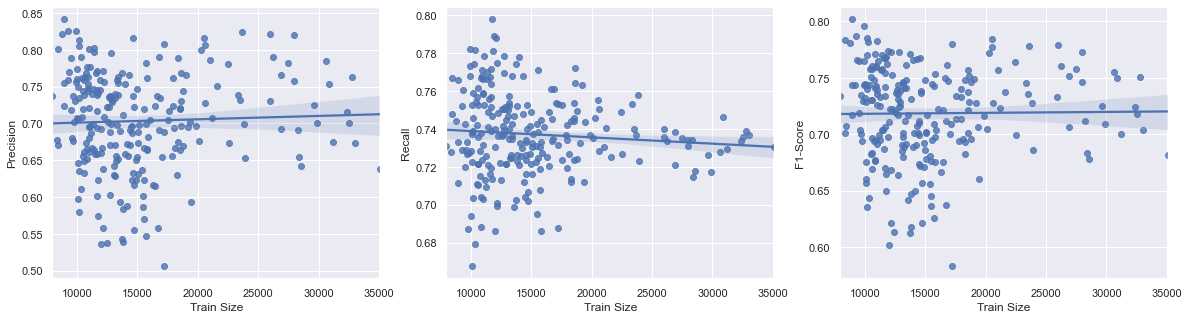

In [5]:
import seaborn as sns
sns.set()
fig, axes = pp.subplots(figsize=(20, 5), nrows=1, ncols=3)
sns.regplot(x='train_size', y='precision', data=results, ax=axes[0])
axes[0].set_xlabel('Train Size')
axes[0].set_ylabel('Precision')
sns.regplot(x='train_size', y='recall', data=results, ax=axes[1])
axes[1].set_xlabel('Train Size')
axes[1].set_ylabel('Recall')
sns.regplot(x='train_size', y='f1_score', data=results, ax=axes[2])
axes[2].set_xlabel('Train Size')
axes[2].set_ylabel('F1-Score');

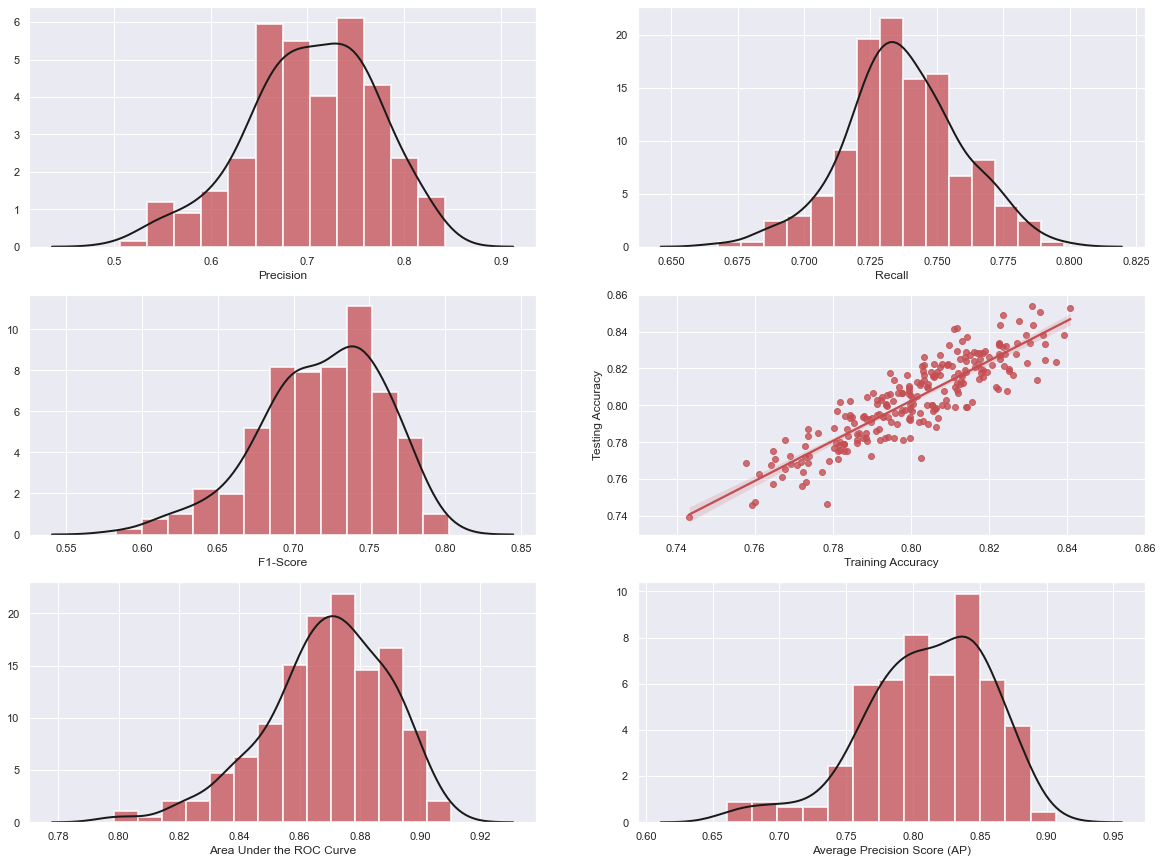

In [22]:
fig, axes = pp.subplots(figsize=(20, 15), nrows=3, ncols=2)
hist_kws = {'linewidth': 2, 'alpha': .75, 'color': 'r'}
kde_kws = {'color': 'k', 'lw': 2}
sns.distplot(results.precision, ax=axes[0, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 0].set_xlabel('Precision')
sns.distplot(results.recall, ax=axes[0, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 1].set_xlabel('Recall')
sns.distplot(results.f1_score, ax=axes[1, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[1, 0].set_xlabel('F1-Score')
sns.regplot(x='train_accuracy', y='test_accuracy', data=results, ax=axes[1,1], color='r')
axes[1, 1].set_xlim([.73, .86])
axes[1, 1].set_ylim([.73, .86])
axes[1, 1].set_xlabel('Training Accuracy')
axes[1, 1].set_ylabel('Testing Accuracy')
sns.distplot(results.auc, ax=axes[2, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 0].set_xlabel('Area Under the ROC Curve')
sns.distplot(results.ap, ax=axes[2, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 1].set_xlabel('Average Precision Score (AP)');

In [29]:
results.loc[:, ['C', 'class_1_weight']].value_counts()

C    class_1_weight
3.0  1.0               240
dtype: int64

In [12]:
best_f1 = results[results.f1_score == results.f1_score.max()]
row_num = list(keys).index(best_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1441
           1       0.84      0.77      0.80      1491

    accuracy                           0.81      2932
   macro avg       0.81      0.81      0.81      2932
weighted avg       0.81      0.81      0.81      2932



In [13]:
worst_f1 = results[results.f1_score == results.f1_score.min()]
row_num = list(keys).index(worst_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2866
           1       0.51      0.69      0.58       759

    accuracy                           0.79      3625
   macro avg       0.71      0.76      0.72      3625
weighted avg       0.82      0.79      0.80      3625



In [39]:
# Baseline Model
logit = LogisticRegression(max_iter=1000)
index = pd.MultiIndex.from_tuples(keys, names=['orgAirport', 'Month'])
results_baseline = pd.DataFrame({'train_size': np.empty(len(keys)), 'test_size': np.empty(len(keys)), 
                        'precision': np.empty(len(keys)), 'recall': np.empty(len(keys)), 
                        'f1_score': np.empty(len(keys)), 'auc': np.empty(len(keys)),  
                        'train_accuracy': np.empty(len(keys)), 'test_accuracy': np.empty(len(keys)),
                        'ap': np.empty(len(keys))},
                       index=index)
report = []
bar = progressbar.ProgressBar(max_value=len(keys))

for i, key in enumerate(keys):
    df = grouped.get_group(key)
    X = df.drop(labels=['month', 'dayofYear', 'orgAirport', 'tailNum', 'delayed'], axis=1)
    X = pd.get_dummies(X, columns=cols, prefix=cols)
    y = df.delayed.values
    X = maxabs_scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, shuffle=True, random_state=14)
    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_test)
    report.append(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, logit.predict_proba(X_test)[:, 1])
    results_baseline.loc[key, 'train_size'] = X_train.shape[0]
    results_baseline.loc[key, 'test_size'] = X_test.shape[0]
    results_baseline.loc[key, 'precision'] = precision_score(y_test, y_pred)
    results_baseline.loc[key, 'recall'] = recall_score(y_test, y_pred)
    results_baseline.loc[key, 'f1_score'] = f1_score(y_test, y_pred)
    results_baseline.loc[key, 'auc'] = auc(fpr, tpr)
    results_baseline.loc[key, 'ap'] = average_precision_score(y_test, logit.predict_proba(X_test)[:, 1])
    results_baseline.loc[key, 'train_accuracy'] = accuracy_score(y_train, logit.predict(X_train))
    results_baseline.loc[key, 'test_accuracy'] = accuracy_score(y_test, logit.predict(X_test))
    bar.update(i+1)

100% (240 of 240) |######################| Elapsed Time: 0:02:52 ETA:  00:00:00

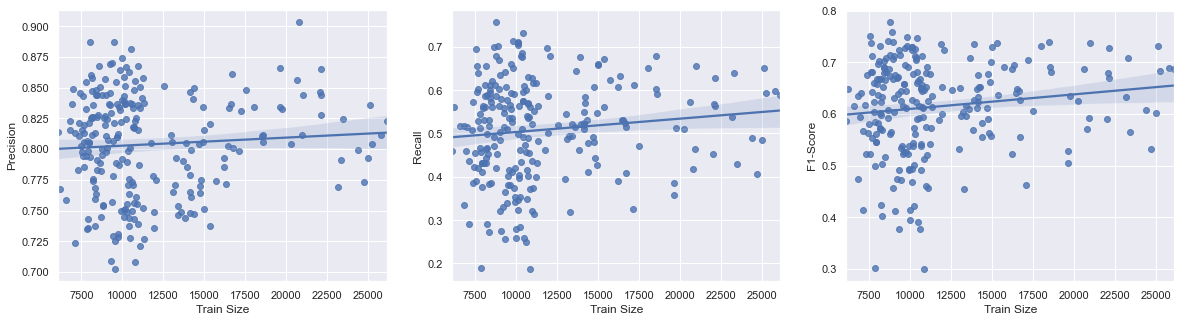

In [40]:
fig, axes = pp.subplots(figsize=(20, 5), nrows=1, ncols=3)
sns.regplot(x='train_size', y='precision', data=results_baseline, ax=axes[0])
axes[0].set_xlabel('Train Size')
axes[0].set_ylabel('Precision')
sns.regplot(x='train_size', y='recall', data=results_baseline, ax=axes[1])
axes[1].set_xlabel('Train Size')
axes[1].set_ylabel('Recall')
sns.regplot(x='train_size', y='f1_score', data=results_baseline, ax=axes[2])
axes[2].set_xlabel('Train Size')
axes[2].set_ylabel('F1-Score');

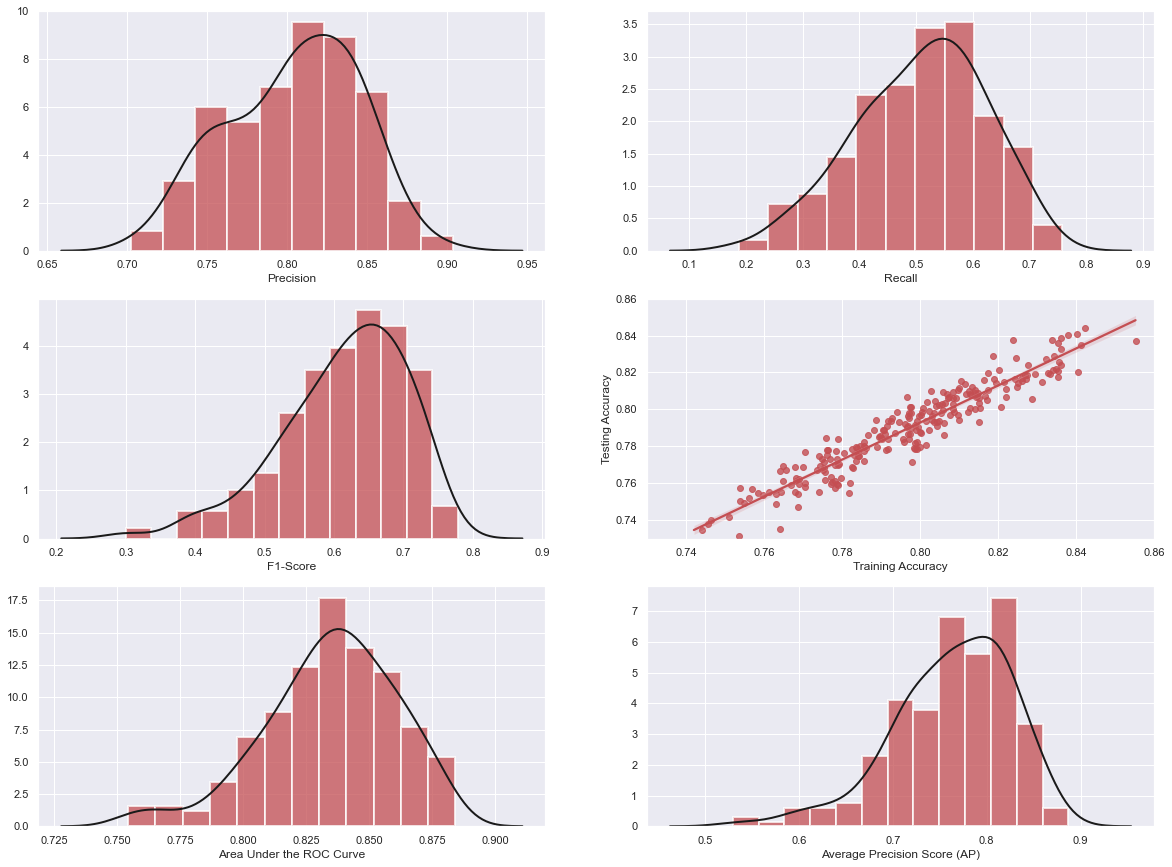

In [41]:
fig, axes = pp.subplots(figsize=(20, 15), nrows=3, ncols=2)
hist_kws = {'linewidth': 2, 'alpha': .75, 'color': 'r'}
kde_kws = {'color': 'k', 'lw': 2}
sns.distplot(results_baseline.precision, ax=axes[0, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 0].set_xlabel('Precision')
sns.distplot(results_baseline.recall, ax=axes[0, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 1].set_xlabel('Recall')
sns.distplot(results_baseline.f1_score, ax=axes[1, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[1, 0].set_xlabel('F1-Score')
sns.regplot(x='train_accuracy', y='test_accuracy', data=results_baseline, ax=axes[1,1], color='r')
axes[1, 1].set_xlim([.73, .86])
axes[1, 1].set_ylim([.73, .86])
axes[1, 1].set_xlabel('Training Accuracy')
axes[1, 1].set_ylabel('Testing Accuracy')
sns.distplot(results_baseline.auc, ax=axes[2, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 0].set_xlabel('Area Under the ROC Curve')
sns.distplot(results_baseline.ap, ax=axes[2, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 1].set_xlabel('Average Precision Score (AP)');

In [42]:
best_f1 = results_baseline[results_baseline.f1_score == results_baseline.f1_score.max()]
row_num = list(keys).index(best_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1441
           1       0.80      0.76      0.78      1491

    accuracy                           0.78      2932
   macro avg       0.78      0.78      0.78      2932
weighted avg       0.78      0.78      0.78      2932



In [43]:
worst_f1 = results_baseline[results_baseline.f1_score == results_baseline.f1_score.min()]
row_num = list(keys).index(worst_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2866
           1       0.76      0.19      0.30       759

    accuracy                           0.82      3625
   macro avg       0.79      0.59      0.60      3625
weighted avg       0.81      0.82      0.77      3625



In [48]:
results_baseline.mean(axis=0)

train_size        11677.270833
test_size          3892.916667
precision             0.803841
recall                0.508605
f1_score              0.614574
auc                   0.834693
train_accuracy        0.796895
test_accuracy         0.789729
ap                    0.763657
dtype: float64

In [45]:
results.mean(axis=0)

train_size        15167.891667
test_size          3892.916667
precision             0.703444
recall                0.737137
f1_score              0.718527
auc                   0.869145
C                     3.000000
class_1_weight        1.000000
train_accuracy        0.800697
test_accuracy         0.803177
ap                    0.810416
dtype: float64